Импортируем необходимые библиотеки

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder


Получим данные

In [75]:
data = pd.read_csv("../jupyter/data/train.csv")

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Проанализируем наши данные

In [76]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

Проверим на дубликаты

In [77]:
missing_data = data.isnull().sum()
print("Пропущенные значения:\n", missing_data)

Пропущенные значения:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Повторно визуализировать тренировочную выборку не будем, мы сделали это в ```../jupyter/jupyter.ipynb```

## Предобработаем данные

Преобразуем не числовые категориальные признаки в числовые

In [78]:
data['Sex'].map({'male': 0, 'female': 1})
data['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

0      2.0
1      0.0
2      2.0
3      2.0
4      2.0
      ... 
886    2.0
887    2.0
888    2.0
889    0.0
890    1.0
Name: Embarked, Length: 891, dtype: float64

Также при анализе данных мы увидели, что у нас отстутствуют значения в столбце `Age`, `Cabin` и `Embarked`

In [79]:
# Заполнение пропусков в Age медианой
data['Age'].fillna(data['Age'].median(), inplace=True)

/var/folders/17/gx9shr111892mg1s5nnz003h0000gn/T/ipykernel_30398/238996323.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)


In [80]:
# Заполнение пропусков в 'Embarked' модой
embarked_imputer = SimpleImputer(strategy='most_frequent')
data['Embarked'] = embarked_imputer.fit_transform(data[['Embarked']]).flatten()

Создадим новый признак (возможно, это улучшит качество наших моделей)

In [81]:
# Создание нового признака FamilySize
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1


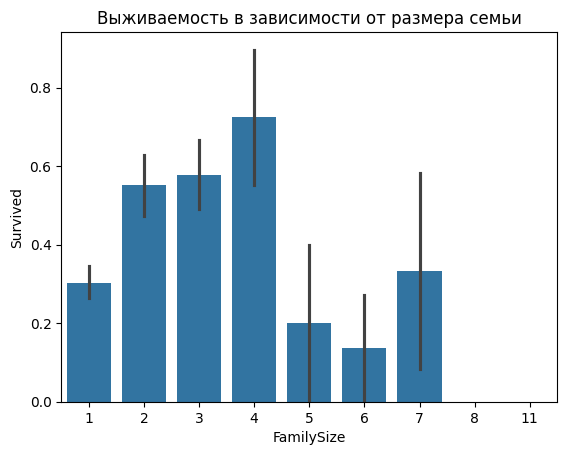

In [82]:
sns.barplot(data=data, x='FamilySize', y='Survived')
plt.title("Выживаемость в зависимости от размера семьи")
plt.show()


Удалим признаки, которые не влияют на то, выжил человек или нет

In [83]:
data.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

Задача - получить значения метрик лучше, чем:
- Для `DecisionTreeClassifier`
  - `precision` для выживших --- 0.79
  - `recall` для выживших --- 0.72
  - `f1_score` для выживших --- 0.75
- Для `RandomForestClassifier`
  - `accuracy` --- 0.8
- Для `LogisticRegression`
  - `precision` для погибших --- 0.81
  - `recall` для погибших --- 0.88
- Для `LinearRegression`
  - `RootMeanSquaredError` для возраста пассажиров --- 10.7

Еще раз посмотрим на данные, нужно ли нам масштабировать выборку?

- Survived: 0 или 1 (целевой признак)
<br>
<br>
- Pclass: 1, 2, 3 (категориальный признак)
- Sex: мужской/женский (категориальный признак)
- Embarked: порт посадки (категориальный признак)
<br>
<br>
- Name: строка (не используется в обучении)
- Ticket: строка (не используется в обучении)
- Cabin: строка (не используется в обучении)
<br>
<br>
- Age: числовой признак (возраст пассажира)
- SibSp: количество братьев/сестёр на борту
- Parch: количество родителей/детей на борту
- Fare: стоимость билета
- FamilySize: Размер семьи

Чиловые признаки имеют разные диапазоны значений. Например, `Fare` может иметь большие значения, а `Age` — меньшие. Это может привести к дисбалансу в влиянии признаков на модель, если используется модель, чувствительная к масштабу (RandomForest и DecisionTree не чувствительны к масштабу данных, в отличие от линейной и логистической регрессии)

In [84]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,0,3,male,22.0,1,0,7.2500,S,2
1,1,1,female,38.0,1,0,71.2833,C,2
2,1,3,female,26.0,0,0,7.9250,S,1
3,1,1,female,35.0,1,0,53.1000,S,2
4,0,3,male,35.0,0,0,8.0500,S,1


In [85]:
# Разделение данных
X = data.drop('Survived', axis=1)
y = data['Survived']

# Кодируем категориальные признаки
label_encoder = LabelEncoder()
X['Sex'] = label_encoder.fit_transform(X['Sex'])  # male -> 0, female -> 1
X['Embarked'] = label_encoder.fit_transform(X['Embarked'].astype(str))  # Пример для Embarked

# Масштабируем только числовые признаки
scaler = StandardScaler()
X[['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']] = scaler.fit_transform(X[['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']])

X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,3,1,-0.565736,0.432793,-0.473674,-0.502445,2,0.059160
1,1,0,0.663861,0.432793,-0.473674,0.786845,0,0.059160
2,3,0,-0.258337,-0.474545,-0.473674,-0.488854,2,-0.560975
3,1,0,0.433312,0.432793,-0.473674,0.420730,2,0.059160
4,3,1,0.433312,-0.474545,-0.473674,-0.486337,2,-0.560975
...,...,...,...,...,...,...,...,...
886,2,1,-0.181487,-0.474545,-0.473674,-0.386671,2,-0.560975
887,1,0,-0.796286,-0.474545,-0.473674,-0.044381,2,-0.560975
888,3,0,-0.104637,0.432793,2.008933,-0.176263,2,1.299429
889,1,1,-0.258337,-0.474545,-0.473674,-0.044381,0,-0.560975


Разделим данные на тестовую и обучающую выборку

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Обучаем модели

In [87]:
# DecisionTreeClassifier

# Настройка параметров для GridSearchCV
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Инициализация DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Инициализация GridSearchCV
grid_search_dt = GridSearchCV(dt_clf, param_grid_dt, cv=5, n_jobs=-1, scoring='accuracy')

# Обучение модели
grid_search_dt.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры DecisionTreeClassifier:", grid_search_dt.best_params_)

# Получение лучших предсказаний
y_pred_dt = grid_search_dt.predict(X_test)

# Метрики
print("Decision Tree - GridSearchCV:")
print(classification_report(y_test, y_pred_dt))

Лучшие параметры DecisionTreeClassifier: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Decision Tree - GridSearchCV:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [88]:
# RandomForestClassifier

# Настройка параметров для RandomizedSearchCV
param_dist_rf = {
    'n_estimators': np.arange(50, 200, 50),
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Инициализация RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Инициализация RandomizedSearchCV
random_search_rf = RandomizedSearchCV(rf_model, param_dist_rf, n_iter=10, cv=5, random_state=42, n_jobs=-1, scoring='accuracy')

# Обучение модели
random_search_rf.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры RandomForestClassifier:", random_search_rf.best_params_)

# Получение лучших предсказаний
y_pred_rf = random_search_rf.predict(X_test)

# Метрики
print("Random Forest - RandomizedSearchCV:")
print(classification_report(y_test, y_pred_rf))

Лучшие параметры RandomForestClassifier: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'bootstrap': False}
Random Forest - RandomizedSearchCV:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       105
           1       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [89]:

# LogisticRegression

# Настройка параметров для GridSearchCV
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 500, 1000]
}

# Инициализация LogisticRegression
lr_model = LogisticRegression(random_state=42)

# Инициализация GridSearchCV
grid_search_lr = GridSearchCV(lr_model, param_grid_lr, cv=5, n_jobs=-1, scoring='accuracy')

# Обучение модели
grid_search_lr.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры LogisticRegression:", grid_search_lr.best_params_)

# Получение лучших предсказаний
y_pred_lr = grid_search_lr.predict(X_test)

# Метрики
print("Logistic Regression - GridSearchCV:")
print(classification_report(y_test, y_pred_lr))

Лучшие параметры LogisticRegression: {'C': 1, 'max_iter': 100, 'solver': 'liblinear'}
Logistic Regression - GridSearchCV:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       105
           1       0.79      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



Проверим, есть ли у нас нулевые значения в столбце `Age `

In [90]:
sum(data['Age'].isnull())

0

In [95]:
# Создаем X_age и y_age для задачи регрессии
X_age = X.copy()  # Копируем все данные X
X_age['Survived'] = y  # Добавляем целевую переменную 'Survived' в X

# Убираем колонку 'Age' из признаков
X_age = X_age.drop('Age', axis=1)

# Целевая переменная для задачи регрессии
y_age = X['Age']  # Используем только 'Age' как целевую переменную

# Разделение на тренировочную и тестовую выборки
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_age, y_age, test_size=0.2, random_state=42)

# Настройка параметров для RandomizedSearchCV
param_dist_lr_reg = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Инициализация LinearRegression
lr_reg = LinearRegression()

# Инициализация RandomizedSearchCV
random_search_lr_reg = RandomizedSearchCV(lr_reg, param_dist_lr_reg, n_iter=10, cv=5, random_state=42, n_jobs=-1, scoring='neg_root_mean_squared_error')

# Обучение модели
random_search_lr_reg.fit(X_train_age, y_train_age)

# Лучшие параметры
print("Лучшие параметры LinearRegression:", random_search_lr_reg.best_params_)

# Оценка модели
score = random_search_lr_reg.score(X_test_age, y_test_age)
print(f'R-squared на валидационной выборке: {-score}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие параметры LinearRegression: {'positive': False, 'fit_intercept': True}
R-squared на валидационной выборке: 0.8838640573027715
